In [26]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt

# Carregar dataset
df = pd.read_csv("data/dataset.csv")

# Eliminar id
df = df.drop(columns=["id"])

# Separar target
X = df.drop(columns=["target_variable"])
y = df["target_variable"]

# Definir variables categòriques (les que són binàries o categories)
categorical_features = [
    "competitor_Z",
    "competitor_X",
    "competitor_Y",
    "cust_in_iberia"
]

# Train/test split estratificat
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Crear i entrenar model CatBoost
model = CatBoostClassifier(
    iterations=700,          # nombre d’iteracions (arbres)
    depth=8,                 # profunditat màxima dels arbres
    subsample=1.0,
    learning_rate=0.1,      # taxa d’aprenentatge
    l2_leaf_reg=1,
    loss_function="Logloss", # funció de pèrdua
    eval_metric="F1",        # mètrica d’avaluació
    random_seed=42,
    verbose=100              # mostra progress cada 100 iteracions
)

model.fit(X_train, y_train, cat_features=categorical_features)

# Prediccions
y_val_proba = model.predict_proba(X_test)[:, 1]

# Threshold tuning per maximitzar F1
thresholds = np.linspace(0.1, 0.9, 81)
best_f1, best_t = -1, None
for t in thresholds:
    y_val_pred = (y_val_proba >= t)
    f1 = f1_score(y_test, y_val_pred)
    if f1 > best_f1:
        best_f1, best_t = f1, t

print("Best threshold:", best_t)
print("Test F1 at best threshold:", best_f1)

# Altres mètriques amb el llindar òptim
y_test_pred = (y_val_proba >= best_t)
print("Accuracy:", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred))
print("Recall:", recall_score(y_test, y_test_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_pred))


0:	learn: 0.6328002	total: 4.3ms	remaining: 3s
100:	learn: 0.7235056	total: 367ms	remaining: 2.18s
200:	learn: 0.7816410	total: 750ms	remaining: 1.86s
300:	learn: 0.8173070	total: 1.12s	remaining: 1.48s
400:	learn: 0.8415548	total: 1.46s	remaining: 1.09s
500:	learn: 0.8571957	total: 1.78s	remaining: 709ms
600:	learn: 0.8702425	total: 2.1s	remaining: 347ms
699:	learn: 0.8799147	total: 2.43s	remaining: 0us
Best threshold: 0.41000000000000003
Test F1 at best threshold: 0.8166259168704156
Accuracy: 0.8119777158774373
Precision: 0.7545180722891566
Recall: 0.8898756660746003
Confusion Matrix:
 [[2824  978]
 [ 372 3006]]


In [17]:
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostClassifier

cat_param_grid = {
    'iterations': [500, 700], # Equivalent to n_estimators
    'learning_rate': [0.05, 0.1],
    'depth': [4, 6, 8], # Equivalent to max_depth
    'l2_leaf_reg': [1, 3, 5], # Regularization parameter
    'subsample': [0.7, 0.9, 1.0],
}

xgb = CatBoostClassifier(
    random_state=42,
    eval_metric="Logloss",
    scale_pos_weight=1 # Explicitly set to 1 (or just remove it, 1 is default)
)

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=cat_param_grid,
    n_iter=25,
    cv=3,
    scoring='f1',  # Still optimizing for F1!
    n_jobs=-1,
    verbose=2,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

# 4. Get the best model
print(f"Best parameters found: {random_search.best_params_}")
best_cat_model = random_search.best_estimator_

# 5. Evaluate the best model
y_pred = best_cat_model.predict(X_test_scaled)

print("--- Best Model Performance ---")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1:", f1_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
0:	learn: 0.6804166	total: 52.2ms	remaining: 26s
1:	learn: 0.6701698	total: 55.2ms	remaining: 13.8s
2:	learn: 0.6620370	total: 59ms	remaining: 9.77s
3:	learn: 0.6553308	total: 62.4ms	remaining: 7.74s
4:	learn: 0.6500517	total: 65.4ms	remaining: 6.48s
5:	learn: 0.6452963	total: 68.5ms	remaining: 5.64s
6:	learn: 0.6418133	total: 71.2ms	remaining: 5.01s
7:	learn: 0.6391863	total: 74.4ms	remaining: 4.57s
8:	learn: 0.6365044	total: 79ms	remaining: 4.31s
9:	learn: 0.6343746	total: 83.9ms	remaining: 4.11s
10:	learn: 0.6321160	total: 86.9ms	remaining: 3.86s
11:	learn: 0.6303256	total: 94.9ms	remaining: 3.86s
12:	learn: 0.6283858	total: 97.7ms	remaining: 3.66s
13:	learn: 0.6267759	total: 102ms	remaining: 3.53s
14:	learn: 0.6254059	total: 105ms	remaining: 3.4s
0:	learn: 0.6779090	total: 56.1ms	remaining: 28s
15:	learn: 0.6244907	total: 114ms	remaining: 3.44s
16:	learn: 0.6235522	total: 117ms	remaining: 3.32s
0:	learn: 0.6810877	total: 

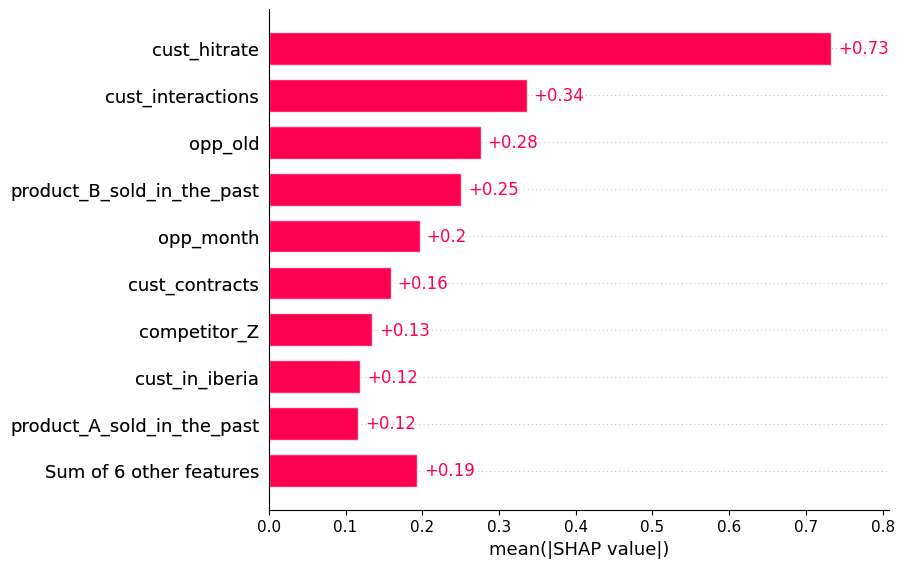

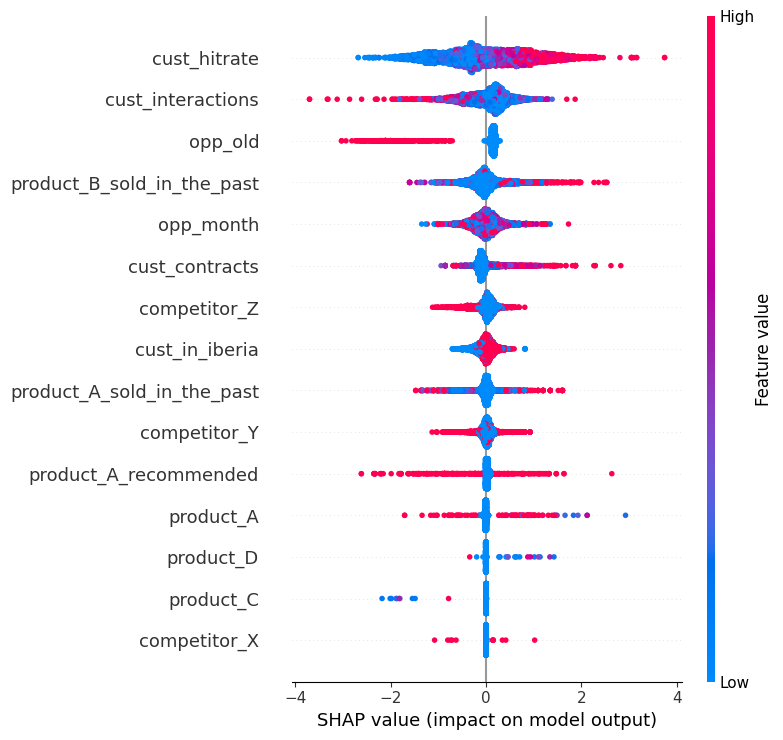

In [18]:
import shap

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
# Assuming 'best_cat_model' is your fitted CatBoost model
cat_explainer = shap.TreeExplainer(best_cat_model)
cat_shap_values = cat_explainer(X_test_scaled_df)

# Generate Plots:
shap.plots.bar(cat_shap_values)
shap.summary_plot(cat_shap_values, X_test_scaled)

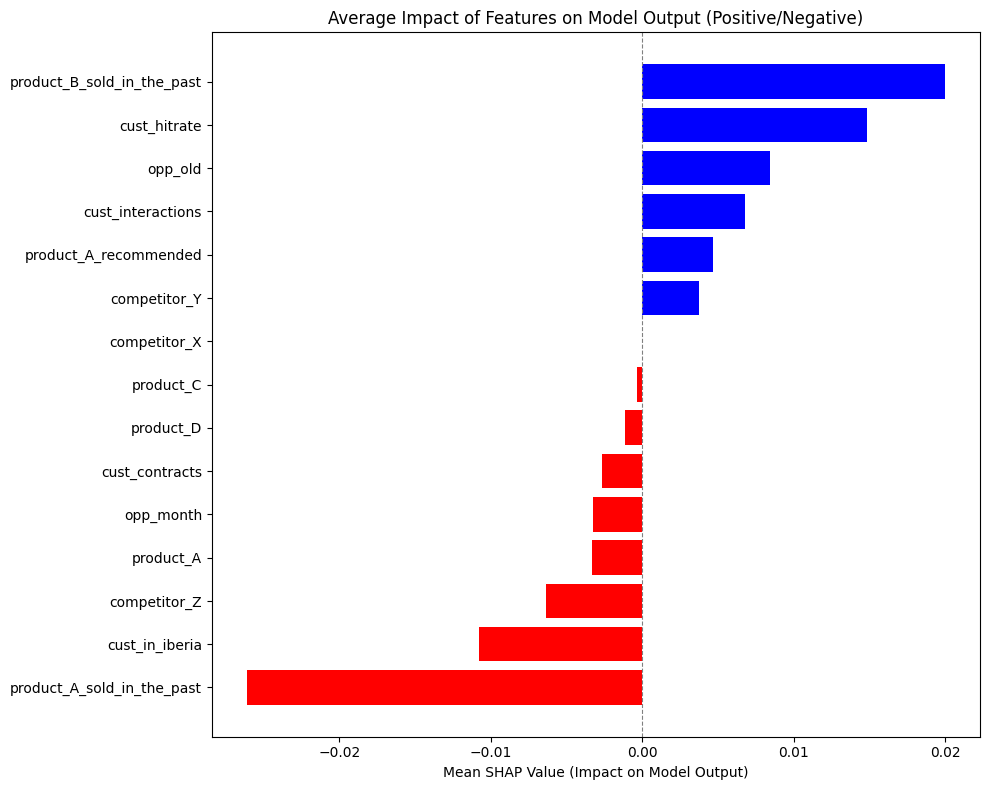

In [24]:
import shap
import matplotlib.pyplot as plt
import numpy as np # For calculating the mean

# Assuming shap_values and X.columns are already defined and shap_values.feature_names is set

# Calculate the mean SHAP value for each feature
# This will preserve the sign (positive or negative)
mean_shap_values = cat_shap_values.values.mean(axis=0)

# Create a DataFrame for easier plotting and sorting
shap_df = pd.DataFrame({
    'feature': X.columns,
    'mean_shap_value': mean_shap_values
})

# Sort the features by their mean SHAP value for a cleaner plot
shap_df = shap_df.sort_values(by='mean_shap_value', ascending=True)

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.barh(shap_df['feature'], shap_df['mean_shap_value'],
         color=['red' if x < 0 else 'blue' for x in shap_df['mean_shap_value']]) # Color based on sign
plt.xlabel("Mean SHAP Value (Impact on Model Output)")
plt.title("Average Impact of Features on Model Output (Positive/Negative)")
plt.axvline(x=0, color='grey', linestyle='--', linewidth=0.8) # Add a vertical line at 0 for separation
plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()

## Model-inbuilt feature importance

                       feature  importance
6                 cust_hitrate   23.690536
7            cust_interactions   19.808609
1   product_B_sold_in_the_past   14.148402
9                    opp_month   12.384414
0   product_A_sold_in_the_past    5.702677
11                competitor_Z    5.162773
8               cust_contracts    4.620209
14              cust_in_iberia    4.147623
13                competitor_Y    3.984997
10                     opp_old    3.280733
2        product_A_recommended    2.113178
3                    product_A    0.683823
5                    product_D    0.112078
12                competitor_X    0.101339
4                    product_C    0.058610


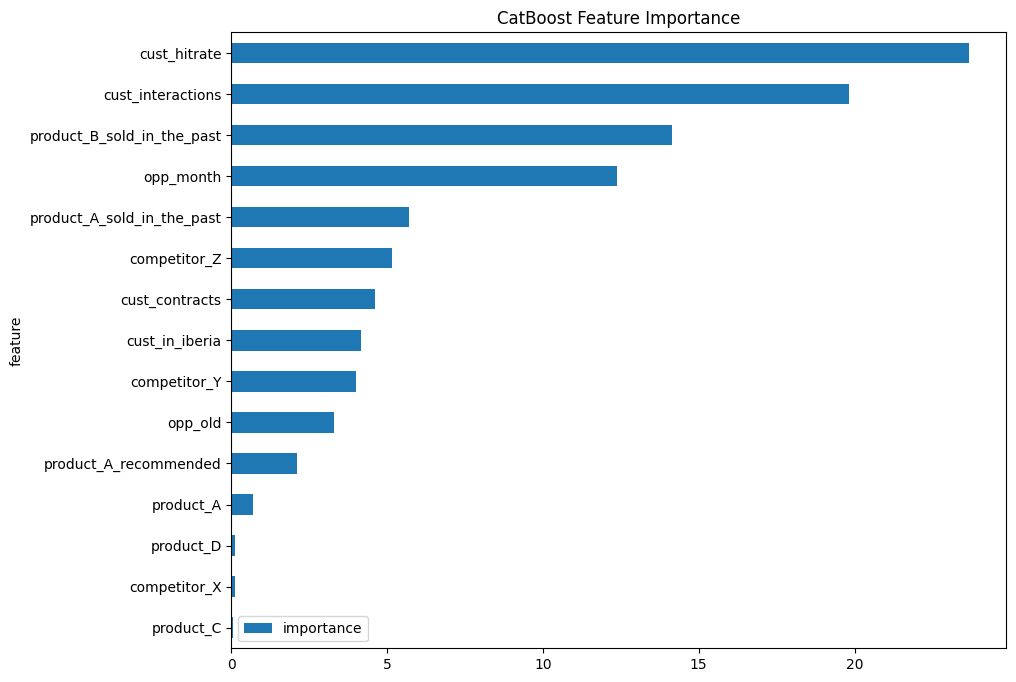

In [28]:
# Get the feature importances
importances = best_cat_model.feature_importances_

# Get your feature names (assuming 'X' is your original unscaled DataFrame)
feature_names = X.columns

# Create a simple bar plot
feat_imp_df = pd.DataFrame({'feature': feature_names, 'importance': importances})
print(feat_imp_df.sort_values(by='importance', ascending=False))

# You can plot this with matplotlib/seaborn
feat_imp_df.sort_values(by='importance').plot(kind='barh', x='feature', y='importance', figsize=(10, 8))
plt.title("CatBoost Feature Importance")
plt.show()